# Car Price Prediction (XGBoost Regression)

# Google Colab Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1XWuTeIBKUBkJWJePgw-9XWv0O5XShklj#scrollTo=xRKjhM0W0fNx)


In [ ]:
# Install xgboost if needed
try:
    import xgboost
except ImportError:
    !pip -q install xgboost


In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBRegressor


In [ ]:
REQUIRED_COLUMNS = [
    'brand', 'model', 'min_cost_price', 'max_cost_price', 'vehicle_age', 'km_driven',
    'seller_type', 'fuel_type', 'transmission_type', 'mileage', 'engine', 'max_power',
    'seats', 'selling_price'
]
MISSING_TOKENS = ['', 'NA', 'N/A', 'null', '-', '--']
CATEGORICAL_COLS = ['brand', 'model', 'seller_type', 'fuel_type', 'transmission_type']

DROP_COST_BOUNDS = False
RARE_MODEL_MIN_COUNT = 20
USE_PREENCODED_CATEGORICALS = True


In [ ]:
def _standardize_columns(df):
    df.columns = [c.strip().lower() for c in df.columns]
    return df

def _replace_missing_tokens(df):
    return df.replace(MISSING_TOKENS, np.nan)

def _assert_required_columns(df):
    missing = [c for c in REQUIRED_COLUMNS if c not in df.columns]
    if missing:
        raise ValueError(f'Missing required columns: {missing}')

def _coerce_numeric_series(series):
    series = series.where(series.notna(), np.nan)
    as_str = series.astype(str)
    cleaned = as_str.str.replace(r'[^0-9.\-]', '', regex=True)
    cleaned = cleaned.replace('', np.nan)
    return pd.to_numeric(cleaned, errors='coerce')

def _clip_invalid_values(df):
    if 'km_driven' in df.columns:
        df.loc[df['km_driven'] < 0, 'km_driven'] = np.nan
    if 'seats' in df.columns:
        df.loc[df['seats'] <= 0, 'seats'] = np.nan
    for col in ['mileage', 'engine', 'max_power']:
        if col in df.columns:
            df.loc[df[col] <= 0, col] = np.nan
    for col in ['min_cost_price', 'max_cost_price', 'selling_price']:
        if col in df.columns:
            df.loc[df[col] < 0, col] = np.nan
    return df

def _group_rare_models(df, min_count):
    if 'model' not in df.columns:
        return df
    counts = df['model'].value_counts(dropna=False)
    rare_models = counts[counts < min_count].index
    df['model'] = df['model'].where(~df['model'].isin(rare_models), 'Other')
    return df

def _process_vehicle_age(df, reference_date=None):
    if 'vehicle_age' not in df.columns:
        return df, reference_date

    raw = df['vehicle_age']
    numeric = _coerce_numeric_series(raw)
    median_val = numeric.median(skipna=True)

    if reference_date is None:
        reference_date = pd.Timestamp.today().normalize()
    else:
        reference_date = pd.to_datetime(reference_date).normalize()

    if pd.isna(median_val):
        df['vehicle_age_years'] = np.nan
        df = df.drop(columns=['vehicle_age'])
        return df, reference_date

    if median_val >= 1e11:
        unit = 'ms'
    elif median_val >= 1e9:
        unit = 's'
    else:
        unit = None

    if unit:
        vehicle_date = pd.to_datetime(numeric, unit=unit, errors='coerce')
        age_years = (reference_date - vehicle_date).dt.days / 365.25
        df['vehicle_age_years'] = age_years
        df['vehicle_year'] = vehicle_date.dt.year
    else:
        df['vehicle_age_years'] = numeric

    df = df.drop(columns=['vehicle_age'])
    df.loc[df['vehicle_age_years'] < 0, 'vehicle_age_years'] = np.nan
    return df, reference_date

def _one_hot_encode_categoricals(df):
    present_cols = [c for c in CATEGORICAL_COLS if c in df.columns]
    if not present_cols:
        return df
    for prefix in CATEGORICAL_COLS:
        if any(col.startswith(f'{prefix}__') for col in df.columns):
            return df
    df = df.copy()
    for col in present_cols:
        df[col] = df[col].fillna('Unknown').astype(str)
    encoded = pd.get_dummies(
        df[present_cols], prefix=present_cols, prefix_sep='__', dtype=int
    )
    df = pd.concat([df, encoded], axis=1)
    df = df.drop(columns=present_cols)
    if df.columns.duplicated().any():
        df = df.loc[:, ~df.columns.duplicated()]
    return df

def preprocess_df(df, reference_date=None, drop_cost_bounds=False, rare_model_min_count=20, one_hot_encode=False):
    df = df.copy()
    if df.columns.duplicated().any():
        df = df.loc[:, ~df.columns.duplicated()]
    df = _standardize_columns(df)
    df = _replace_missing_tokens(df)
    _assert_required_columns(df)
    df = df.drop_duplicates()

    df = _group_rare_models(df, rare_model_min_count)
    df, reference_date = _process_vehicle_age(df, reference_date=reference_date)

    numeric_cols = [
        'min_cost_price', 'max_cost_price', 'km_driven', 'mileage',
        'engine', 'max_power', 'seats', 'selling_price'
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = _coerce_numeric_series(df[col])

    df = _clip_invalid_values(df)

    # Leakage risk: min_cost_price and max_cost_price may be close to selling_price.
    if drop_cost_bounds:
        df = df.drop(columns=[c for c in ['min_cost_price', 'max_cost_price'] if c in df.columns])
    else:
        if 'min_cost_price' in df.columns and 'max_cost_price' in df.columns:
            df['cost_mid'] = (df['min_cost_price'] + df['max_cost_price']) / 2
            df['cost_range'] = df['max_cost_price'] - df['min_cost_price']

    if 'km_driven' in df.columns and 'vehicle_age_years' in df.columns:
        df['km_per_year'] = df['km_driven'] / df['vehicle_age_years'].clip(lower=1e-6)

    if one_hot_encode:
        df = _one_hot_encode_categoricals(df)

    return df, reference_date

def build_preprocessor(feature_df, encode_categoricals=True):
    numeric_features = feature_df.select_dtypes(include=['number']).columns.tolist()
    categorical_features = [c for c in feature_df.columns if c not in numeric_features]

    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
    transformers = [('num', numeric_transformer, numeric_features)]

    if encode_categoricals and categorical_features:
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ])
        transformers.append(('cat', categorical_transformer, categorical_features))

    preprocessor = ColumnTransformer(transformers=transformers)
    return preprocessor

def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'R2: {r2:.4f}')
    return preds

def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predicted vs Actual')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--', color='red')
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True)
    plt.title('Residual Distribution')
    plt.xlabel('Residual')
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model):
    preprocessor = model.named_steps['preprocessor']
    xgb_model = model.named_steps['model']
    feature_names = preprocessor.get_feature_names_out()
    importances = xgb_model.feature_importances_

    importance_df = (
        pd.DataFrame({'feature': feature_names, 'importance': importances})
        .sort_values('importance', ascending=False)
        .head(20)
    )

    plt.figure(figsize=(8, 6))
    sns.barplot(data=importance_df, x='importance', y='feature')
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()
    plt.show()


## Load data

In [ ]:
# Mount Google Drive (optional)
colab = False
try:
    from google.colab import drive, files
    drive.mount('/content/drive')
    colab = True
except Exception:
    files = None
if colab :
        csv_path = '/content/drive/MyDrive/ML/PricePredictionCleanedUp.csv'
else :
        csv_path = './PricePredictionCleanedUp.csv'

if not os.path.exists(csv_path) and files is not None:
    print('Cleaned file not found on Drive. Upload raw or cleaned CSV.')
    uploaded = files.upload()
    uploaded_path = next(iter(uploaded.keys()))
    df_raw = pd.read_csv(uploaded_path)
    df_clean, ref_date = preprocess_df(
        df_raw,
        drop_cost_bounds=DROP_COST_BOUNDS,
        rare_model_min_count=RARE_MODEL_MIN_COUNT,
        one_hot_encode=True,
    )
    csv_path = '/content/PricePredictionCleanedUp.csv'
    df_clean.to_csv(csv_path, index=False)

df = pd.read_csv(csv_path)
if df.columns.duplicated().any():
    df = df.loc[:, ~df.columns.duplicated()]
df.head()


Mounted at /content/drive


,min_cost_price,max_cost_price,km_driven,mileage,engine,max_power,seats,selling_price,vehicle_age_years,cost_mid,...,seller_type__Dealer,seller_type__Individual,seller_type__Trustmark Dealer,fuel_type__CNG,fuel_type__Diesel,fuel_type__Electric,fuel_type__LPG,fuel_type__Petrol,transmission_type__Automatic,transmission_type__Manual
0,3070.233205,4002.453282,120000.0,19.70,796.0,46.30,5.0,1032.0,9.0,4.112027e+05,...,0,1,0,0,0,0,0,1,0,1
1,6114.600000,6432.800000,20000.0,18.90,1197.0,82.00,5.0,4730.0,5.0,7.295000e+05,...,0,1,0,0,0,0,0,1,0,1
2,7345.112641,11248.159833,60000.0,17.00,1197.0,80.00,5.0,1849.0,11.0,1.081004e+06,...,0,1,0,0,0,0,0,1,0,1
3,3070.233205,4002.453282,37000.0,20.92,998.0,67.10,5.0,1943.6,9.0,4.112027e+05,...,0,1,0,0,0,0,0,1,0,1
4,8720.400000,11859.400000,30000.0,22.77,1498.0,98.59,5.0,4902.0,6.0,1.196500e+06,...,1,0,0,0,1,0,0,0,0,1


## Train/test split and modeling

In [ ]:
# Redefine evaluate_model locally to fix the 'squared' argument error
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    # Calculate RMSE manually
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'R2: {r2:.4f}')
    return preds

df = _standardize_columns(df)
# Drop duplicate columns that might have been created by standardization
if df.columns.duplicated().any():
    df = df.loc[:, ~df.columns.duplicated()]

if USE_PREENCODED_CATEGORICALS:
    df = df.drop(columns=[c for c in CATEGORICAL_COLS if c in df.columns])

y = df['selling_price']
X = df.drop(columns=['selling_price'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

baseline_preprocessor = build_preprocessor(
    X_train, encode_categoricals=not USE_PREENCODED_CATEGORICALS
)
baseline_model = Pipeline(steps=[
    ('preprocessor', baseline_preprocessor),
    ('model', Ridge(random_state=42)),
])
baseline_model.fit(X_train, y_train)

xgb_preprocessor = build_preprocessor(
    X_train, encode_categoricals=not USE_PREENCODED_CATEGORICALS
)
xgb_model = Pipeline(steps=[
    ('preprocessor', xgb_preprocessor),
    ('model', XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='reg:squarederror',
    )),
])
xgb_model.fit(X_train, y_train)

print('Baseline (Ridge) metrics:')
_ = evaluate_model(baseline_model, X_test, y_test)
print('XGBoost metrics:')
xgb_preds = evaluate_model(xgb_model, X_test, y_test)

Baseline (Ridge) metrics:
MAE: 1593.3381
RMSE: 3618.5764
R2: 0.7741
XGBoost metrics:
MAE: 741.4694
RMSE: 1807.1773
R2: 0.9436


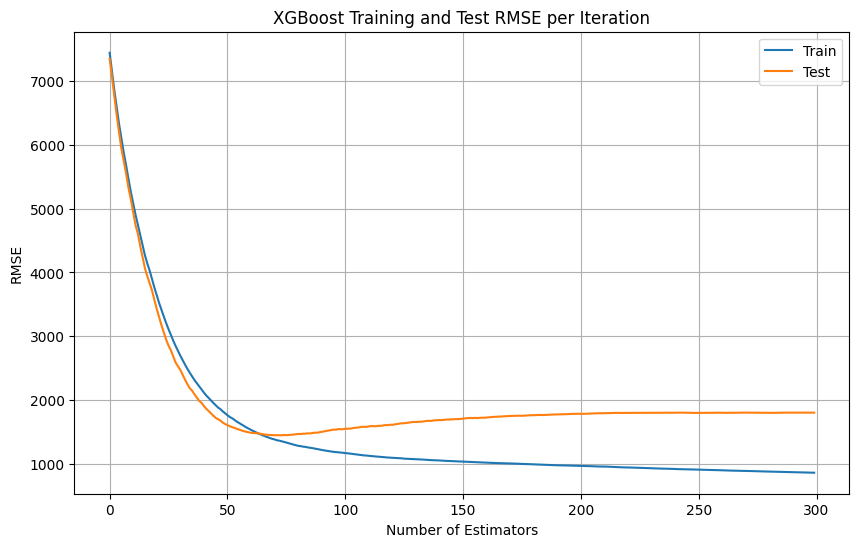

In [ ]:
# Extract preprocessor and regressor from the existing pipeline
preprocessor = xgb_model.named_steps['preprocessor']
regressor = xgb_model.named_steps['model']

# Transform the data so it can be passed to eval_set
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Refit the regressor with eval_set to capture the learning curve
# We use the same parameters as before
regressor.fit(
    X_train_processed, y_train,
    eval_set=[(X_train_processed, y_train), (X_test_processed, y_test)],
    verbose=False
)

# Retrieve performance metrics
results = regressor.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Number of Estimators')
plt.title('XGBoost Training and Test RMSE per Iteration')
plt.grid(True)
plt.show()

## Plots (XGBoost)

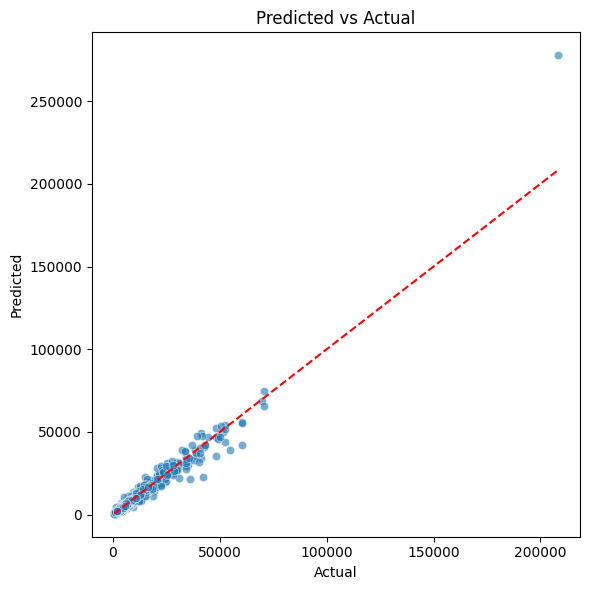

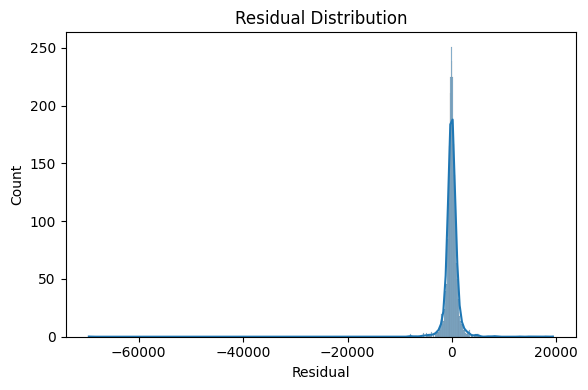

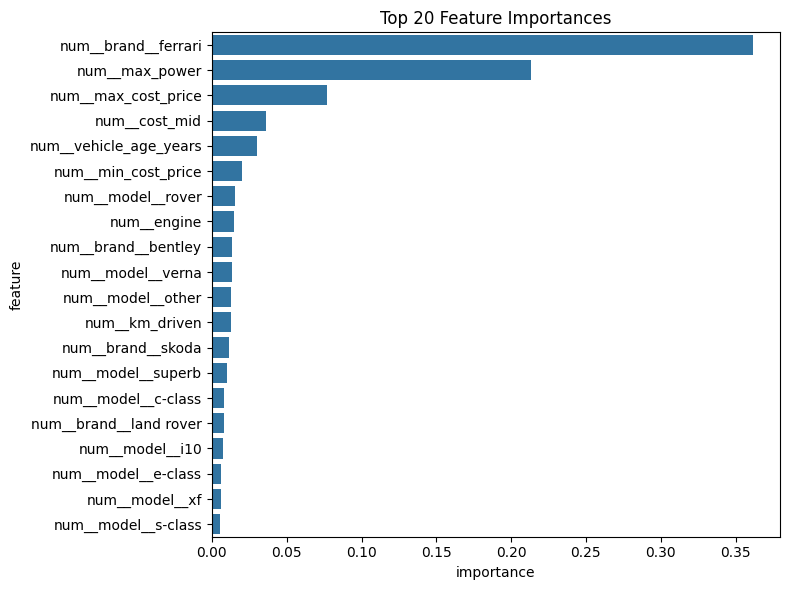

In [ ]:
plot_predictions(y_test, xgb_preds)
plot_residuals(y_test, xgb_preds)
plot_feature_importance(xgb_model)


## Save/load model and booster

In [ ]:
pipeline_path = 'car_price_pipeline.joblib'
joblib.dump(xgb_model, pipeline_path)

booster_path = 'xgboost_price_model.json'
xgb_model.named_steps['model'].get_booster().save_model(booster_path)

loaded_model = joblib.load(pipeline_path)

import xgboost as xgb
booster = xgb.Booster()
booster.load_model(booster_path)


In [ ]:
import os

# Define the target directory on Google Drive
drive_models_dir = '/content/drive/MyDrive/ML/models'

# Create the directory if it doesn't exist
os.makedirs(drive_models_dir, exist_ok=True)

# Define the full path for the JSON file
drive_booster_path = os.path.join(drive_models_dir, 'xgboost_price_model.json')

# Save the model to the Drive path
xgb_model.named_steps['model'].get_booster().save_model(drive_booster_path)

print(f'Model JSON saved to: {drive_booster_path}')

Model JSON saved to: /content/drive/MyDrive/ML/models/xgboost_price_model.json


## Sample prediction

In [ ]:
sample_input = pd.DataFrame([{
    'brand': 'Maruti',
    'model': 'Swift',
    'min_cost_price': 300000,
    'max_cost_price': 450000,
    'vehicle_age': 5,
    'km_driven': 45000,
    'seller_type': 'Individual',
    'fuel_type': 'Petrol',
    'transmission_type': 'Manual',
    'mileage': 18.5,
    'engine': 1197,
    'max_power': 82,
    'seats': 5
}])

sample_for_prep = sample_input.copy()
sample_for_prep['selling_price'] = np.nan
sample_clean, _ = preprocess_df(
    sample_for_prep,
    reference_date=pd.Timestamp.today().normalize(),
    drop_cost_bounds=DROP_COST_BOUNDS,
    rare_model_min_count=1,
    one_hot_encode=True,
)
if USE_PREENCODED_CATEGORICALS:
    sample_clean = sample_clean.drop(columns=[c for c in CATEGORICAL_COLS if c in sample_clean.columns])
sample_clean = sample_clean.drop(columns=['selling_price'])
sample_clean = sample_clean.reindex(columns=X_train.columns, fill_value=np.nan)

prediction = loaded_model.predict(sample_clean)
print('Predicted selling price:', prediction[0])


Predicted selling price: 19152.873


/tmp/ipython-input-3369876350.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned = cleaned.replace('', np.nan)


In [ ]:
import xgboost as xgb
import random

# 1. Define target brands to search for in the test set
target_brands = ['bmw', 'volkswagen', 'mercedes-benz', 'ferrari', 'ford']
samples = []

# 2. Find samples in X_test
print("Selecting samples from X_test...\n")
for brand_key in target_brands:
    # Construct the one-hot encoded column name (e.g., 'brand__bmw')
    col_name = f'brand__{brand_key}'

    if col_name not in X_test.columns:
        print(f"Warning: Brand column '{col_name}' not found in dataset.")
        continue

    # Find indices where this brand is present (value is 1)
    indices = X_test.index[X_test[col_name] == 1].tolist()

    if not indices:
        print(f"No test samples found for brand '{brand_key}'.")
        continue

    # Pick a random sample index for this brand
    idx = random.choice(indices)

    # Extract features and the real target value
    row_features = X_test.loc[[idx]]
    real_price = y_test.loc[idx]

    # Attempt to recover the model name from one-hot columns (for display only)
    model_name = "Unknown"
    model_cols = [c for c in X_test.columns if c.startswith('model__')]
    for mc in model_cols:
        if row_features[mc].values[0] == 1:
            # Remove prefix and format
            model_name = mc.replace('model__', '').title()
            break

    samples.append({
        'brand': brand_key.title(),
        'model': model_name,
        'real_price': real_price,
        'features': row_features
    })

if samples:
    # 3. Prepare data for prediction
    # Concatenate all selected feature rows
    sample_X = pd.concat([s['features'] for s in samples])

    # Transform features using the pipeline's preprocessor (scaling/imputation)
    preprocessor = xgb_model.named_steps['preprocessor']
    X_matrix = preprocessor.transform(sample_X)

    # 4. Load the JSON model from Drive
    json_model_path = '/content/drive/MyDrive/ML/models/xgboost_price_model.json'
    loaded_booster = xgb.Booster()
    loaded_booster.load_model(json_model_path)

    # 5. Predict
    dmatrix = xgb.DMatrix(X_matrix)
    preds = loaded_booster.predict(dmatrix)

    # 6. Display results
    print(f"\nLoaded model from: {json_model_path}\n")
    header = f"{'Brand':<15} {'Model':<20} {'Real Price':>15} {'Predicted':>15} {'Diff %':>10}"
    print(header)
    print("-" * len(header))

    for i, s in enumerate(samples):
        pred = preds[i]
        real = s['real_price']
        diff_pct = ((pred - real) / real) * 100
        print(f"{s['brand']:<15} {s['model']:<20} {real:>15,.2f} {pred:>15,.2f} {diff_pct:>9.1f}%")
else:
    print("No matching samples found in the test set to predict.")

Selecting samples from X_test...

No test samples found for brand 'ferrari'.

Loaded model from: /content/drive/MyDrive/ML/models/xgboost_price_model.json

Brand           Model                     Real Price       Predicted     Diff %
-------------------------------------------------------------------------------
Bmw             Other                      49,020.00       46,009.40      -6.1%
Volkswagen      Vento                       6,011.40        5,141.95     -14.5%
Mercedes-Benz   E-Class                     9,933.00       10,859.03       9.3%
Ford            Ecosport                    3,397.00        3,952.67      16.4%
